In [3]:
from obspy import read_events, Catalog, UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geothermie_plot_function import *

In [4]:
threshold_event_magnitude = 0.5

In [5]:
catalog = read_events('Downloads/geothermie-events-master/geothermie-events-master/Unterhaching/*.xml')
catnew = Catalog()
cat2013 = Catalog()
eventinfo = []
eventinfo2 = []
for event in catalog:
    try:
        if not (event.origins[0]['time'] > UTCDateTime(2013,1,1) and event.origins[0]['time'] < UTCDateTime(2014,1,1)):
            catnew.append(event)
            eventinfo.append([event.origins[0]['time'],event.magnitudes[0].mag])
        else:
            cat2013.append(event)
            eventinfo2.append([event.origins[0]['time'],event.magnitudes[0].mag])
    except:
        pass
catalog = catnew
roundedtimes = []
magnitudes = []
for time in eventinfo:
    rtime = float(UTCDateTime(time[0].year,time[0].month,time[0].day,time[0].hour))
    roundedtimes.append(rtime)
    magnitudes.append(time[1])
roundedtimes, magnitudes = zip(*sorted(zip(roundedtimes, magnitudes)))
print(catalog)
names = 'Time,Flowrate,Temperature,Pressure'
names = names.split(",")
data = pd.read_csv('Dokumente/unterhaching_betriebsdaten_2008-2017/daten20082017.txt',names=names,skiprows=1,delimiter=' ')
N = len(data)
newcol = np.zeros(N)
newcol2 = np.zeros(N)
flc = np.zeros(N)
tc = np.zeros(N)
pc = np.zeros(N)

ievent = 0

eventtimes = np.zeros(N)
eventtimes[0] = 100*365*24
eventtimes[1] = eventtimes[0]+1
newcol2[0] = np.nan
for i in range(1,N):
    if data['Time'][i] in roundedtimes:
        newcol[i] = 1
        N_events_in_this_hour = roundedtimes.count(data['Time'][i])
        
        ## get top magnitude of events in this hour
        mag = max(magnitudes[ievent:ievent+N_events_in_this_hour])
        newcol2[i] = mag
        if mag > threshold_event_magnitude:
            eventtimes[i+1] = 0
        else:
            eventtimes[i+1] = eventtimes[i]+1
        
        ievent += N_events_in_this_hour
    else:
        newcol2[i] = np.nan
        if i!=N-1:
            eventtimes[i+1] = eventtimes[i]+1
        
            
    
    if i==43022:
        roundedtimes2 = []
        magnitudes2 = []
        for time in eventinfo2:
            rtime = float(UTCDateTime(time[0].year,time[0].month,time[0].day,time[0].hour))
            roundedtimes2.append(rtime)
            magnitudes2.append(time[1])
        roundedtimes2, magnitudes2 = zip(*sorted(zip(roundedtimes2, magnitudes2)))
        roundedtimes2 = list(roundedtimes2)
        magnitudes2 = list(magnitudes2)
        roundedtimes2.reverse()
        magnitudes2.reverse()
        check = True
        mag = -100
        eventindex = -1
        while (mag < threshold_event_magnitude and check):
            eventindex += 1
            mag = magnitudes2[eventindex]
            if eventindex==len(magnitudes2):
                check = False
        eventtimes[i] = (float(UTCDateTime(2014,1,1))-roundedtimes2[eventindex])/(60**2)

drop = []
for i in range(N):
    if np.isnan(data['Flowrate'][i]):
        drop.append(i)
data.drop(drop)
N = len(data)

for i in range(1,N-1):
    flc[i] = data['Flowrate'][i+1]-data['Flowrate'][i-1]
    tc[i] = data['Temperature'][i+1]-data['Temperature'][i-1]
    pc[i] = data['Pressure'][i+1]-data['Pressure'][i-1]
    

#data['Flowrate diff'] = flc/2
#data['Temp diff'] = tc/2
#data['Press diff'] = pc/2
data['Quiet time'] = eventtimes
data['Event'] = newcol
data['Magnitude'] = newcol2
names.extend(['Flowrate diff','Temp diff','Press diff','Quiet time','Event','Magnitude'])

509 Event(s) in Catalog:
2010-05-27T16:25:25.312700Z | +48.048,  +11.644 | 0.0839474806054 Ml
2010-01-31T08:00:57.025500Z | +48.048,  +11.643 | 0.039033276658 Ml
...
2019-01-18T21:53:12.483393Z | +48.049,  +11.646 | -0.472072504528 None
2019-12-31T17:47:30.953434Z | +48.045,  +11.644 | -0.497145528261 None
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [6]:
def Confusionmatrix(y,yhat,perc):
    N = len(y)
    C = [[0,0],[0,0]]
    for i in range(N):
        if y[i,0]==1. and yhat[i,0]>=perc:
            C[0][0] += 1
        elif y[i,0]==0. and yhat[i,0]>=perc:
            C[1][0] += 1
        elif y[i,0]==1. and yhat[i,0]<perc:
            C[0][1] += 1
        else:
            C[1][1] += 1
            
    print('True Positives:  ', C[0][0])
    print('False Positives: ', C[1][0])
    print('False Negatives: ', C[0][1])
    print('True Negatives:  ', C[1][1])
    return C

In [7]:
def plot_model_evolution(Loss,b,c,U,V,W):
    fig,ax = plt.subplots(nrows=6,figsize=(15,15),sharex=True)
    ax[0].plot(Loss,label='Loss')
    ax[0].set_yscale('log')
    ax[1].plot(c[:,0],label='c1')
    ax[1].plot(c[:,1],label='c2')
    ax[2].plot(b[:,0],label='b1')
    ax[2].plot(b[:,1],label='b2')
    ax[2].plot(b[:,2],label='b3')
    ax[3].plot(V[:,0,0],label='V11')
    ax[3].plot(V[:,0,1],label='V12')
    ax[3].plot(V[:,0,2],label='V13')
    ax[3].plot(V[:,1,0],label='V21')
    ax[3].plot(V[:,1,1],label='V22')
    ax[3].plot(V[:,1,2],label='V23')
    
    ulabels = [['U11','U12','U13'],['U21','U22','U23'],['U31','U32','U33']]
    wlabels = [['W11','W12','W13'],['W21','W22','W23'],['W31','W32','W33']]
    
    for i in range(3):
        for j in range(3):
            ax[4].plot(U[:,i,j],label=ulabels[i][j])
            ax[5].plot(W[:,i,j],label=wlabels[i][j])
            
    for i in range(6):
        ax[i].legend(fontsize=8)
    plt.show() 

In [8]:
def softmax(xx):
    z = np.zeros(len(xx))
    summa = 0
    for i in range(len(xx)):
        z[i] = np.exp(xx[i])
        summa += np.exp(xx[i])
    return z/summa

In [9]:
def ReLu(xx):
    zz = np.zeros(len(xx))
    for i in range(len(xx)):
        if xx[i]>0:
            zz[i] = xx[i]
    return zz

In [10]:
def delta(xx,yy):
    if xx==yy:
        return 1.
    else:
        return 0.

In [32]:
def initialization(Nit,Vpast):

    U = np.zeros((Nit,3,3))
    W = np.zeros((Nit,3,3))
    b = np.zeros((Nit,3))
    V = np.zeros((Nit,2,3,Vpast))
    c = np.zeros((Nit,2))

    dU = np.zeros((Nit,3,3))
    dW = np.zeros((Nit,3,3))
    db = np.zeros((Nit,3))
    dV = np.zeros((Nit,2,3,Vpast))
    dc = np.zeros((Nit,2))

    yhat = np.zeros((Nit+1,N,2))

    Nrandom = 1000

    for i in range(3):
        for j in range(3):
            U[0,i,j] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom 
            W[0,i,j] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom 
        b[0,i]= (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom  
    for i in range(2):
        for k in range(3):
            for l in range(Vpast):
                V[0,i,k,l] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom 
        c[0,i] = (np.random.randint(0,2*Nrandom)-Nrandom)/Nrandom    

    Loss = np.zeros(Nit)

    return U,W,b,V,c,dU,dW,db,dV,dc,yhat,Loss

In [64]:
def prediction(b,c,U,V,W,x):
    Vpast = np.shape(V)[2]
    N = len(x)
    a = np.zeros((N,3))
    h = np.zeros((N,3))
    o = np.zeros((N,2))
    yhat = np.zeros((N,2))
    a[0] = b + np.dot(U,x[0])
    h[0] = np.tanh(a[0])
    o[0] = c + np.dot(V[:,:,0],h[0])
    yhat[0] = softmax(o[0,:])
    for t in range(1,Vpast):
        a[t] = b + np.dot(W,h[t-1])+np.dot(U,x[t])
        h[t] = np.tanh(a[t])
        hidden = np.zeros(2)
        for j in range(t):
            hidden += np.dot(V[:,:,t-(j+1)],h[j])
        o[t] = c + hidden
        yhat[t] = softmax(o[t,:])
    
    for t in range(Vpast,N):
        a[t] = b + np.dot(W,h[t-1])+np.dot(U,x[t])
        h[t] = np.tanh(a[t])
        hidden = np.zeros(2)
        for j in range(Vpast):
            hidden += np.dot(V[:,:,Vpast-(j+1)],h[t-Vpast+j])
        o[t] = c + hidden
        yhat[t,:] = softmax(o[t,:])
    return h,o,yhat

def get_loss(y,yhat):
    N = len(y)
    Loss = 0
    for t in range(N):
        Loss -= y[t,0]*np.log10(yhat[t,0])+(1-y[t,0])*np.log10(yhat[t,1])
    return Loss

def gradients(h,o,V,W,x,y,yhat):
    Vpast = np.shape(V)[2]
    N = len(x)
    do = np.zeros((N,2))
    for t in range(N):
        do[t,0] = y[t,0]*(1-yhat[t,0])-yhat[t,0]*(1-y[t,0])
        do[t,1] = -y[t,0]*yhat[t,1] * (1-y[t,0])*(1-yhat[t,1])
    do /= np.log(10)
    
    dh = np.zeros((N,3))
    dh[-1] = np.dot(V[:,:,0].transpose(),do[-1])
    
    for t in range(N-2,N-Vpast-1,-1):
        hidden = np.zeros(3)
        for j in range(N-t):
            hidden += np.dot(V[:,:,j].transpose(),do[t+j])
        diag = np.diag(np.array([1-h[t+1,0]**2,1-h[t+1,1]**2,1-h[t+1,2]**2]))
        dh[t] = np.dot(np.dot(W.transpose(),diag),dh[t+1])+hidden
    
    for t in range(N-Vpast-1,-1,-1):
        hidden = np.zeros(3)
        for j in range(Vpast):
            hidden += np.dot(V[:,:,j].transpose(),do[t+j])
        diag = np.diag(np.array([1-h[t+1,0]**2,1-h[t+1,1]**2,1-h[t+1,2]**2]))
        dh[t] = np.dot(np.dot(W.transpose(),diag),dh[t+1])+hidden

    dc = np.zeros(2)
    for i in range(2):
        dc[i] = np.sum(do[:,i])
    db = np.zeros(3)
    dV = np.zeros((2,3,Vpast))
    dW = np.zeros((3,3))
    dU = np.zeros((3,3))
    for i in range(3):
        for t in range(N):
            db[i] += (1-h[t,i]**2)*dh[t,i]
            
    
    for k in range(Vpast):
        for t in range(Vpast,N):
            for i in range(2):
                for j in range(3):
                    dV[i,j,k] += do[t,i]*h[t-k,j]

    for t in range(1,N):
        mat = np.zeros((3,3))
        mat2 = np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                mat[i,j] = dh[t,i] * h[t-1,j]
                mat2[i,j] = dh[t,i] * x[t,j]
        dW += np.dot(np.diag(np.array([1-h[t,0]**2,1-h[t,1]**2,1-h[t,2]**2])),mat)
        dU += np.dot(np.diag(np.array([1-h[t,0]**2,1-h[t,1]**2,1-h[t,2]**2])),mat2)
    return db,dc,do,dU,dV,dW

In [13]:
def mapx(x):
    Nt, Ni = np.shape(x)
    m = np.zeros((Ni,2))
    for i in range(Ni):
        m[i,0] = np.min(x[:,i])
        m[i,1] = np.max(x[:,i])
    newx = np.zeros(np.shape(x))
    for i in range(Ni):
        for t in range(Nt):
            newx[t,i] = (x[t,i]-m[i,0])/(m[i,1]-m[i,0])
    return newx

In [91]:
#data acquisition
N = len(data)
x = [[],[],[]]
y = [[],[]]
index = 0
for i in range(N):
    if not np.isnan(data['Flowrate'][i]):
        x[0].append(data['Flowrate'][i])
        x[1].append(data['Temperature'][i])
        x[2].append(data['Pressure'][i])
        y[0].append(data['Event'][i])
        y[1].append(data['Magnitude'][i])
x = np.array(x).transpose()
y = np.array(y).transpose()
x = mapx(x)
N = len(x)

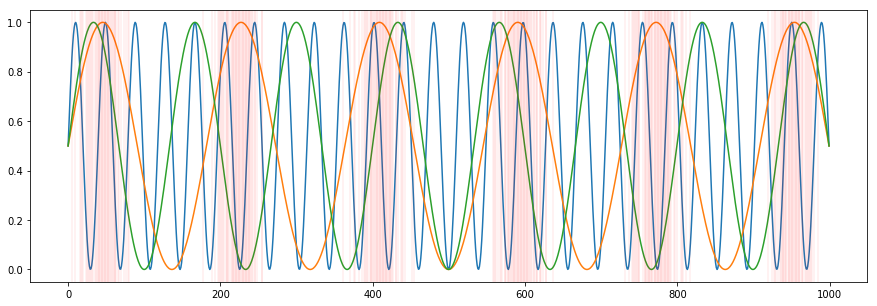

In [86]:
#fake data
N = 1000
x = np.zeros((N,3))
y = np.zeros((N,2))
x[:,0] = (np.sin(np.linspace(0,51*np.pi,N))+1)/2
x[:,1] = (np.sin(np.linspace(0,11*np.pi,N))+1)/2
x[:,2] = (np.sin(np.linspace(0,15*np.pi,N))+1)/2
plt.figure(figsize=(15,5))
plt.plot(x[:,0])
plt.plot(x[:,1])
plt.plot(x[:,2])
xx = []
yy = []
for i in range(N):
    if np.random.randint(100)/100 < x[i,1]**4:
        y[i,0] = 1.
        xx.append(i)
        yy.append(np.max(x[i,0]))
        plt.axvline(i,lw=0.1,c='r')
#plt.scatter(xx,yy,c='r',marker='X')
plt.show()
x = mapx(x)

### RNN-model, fig. 10.4 - Expand V in such a way that o is influenced by past hidden nodes

-- Best training to date for real data, Loss 900.5

It Actually looks quite promising, maybe it needs to be combined with the deep network 

In [92]:
Nit = 1000
eps = 0.0001
Vpast = 5

U,W,b,V,c,dU,dW,db,dV,dc,yhat,Loss = initialization(Nit,Vpast)

for k in range(Nit):
    h,o,yhat[k] = prediction(b[k],c[k],U[k],V[k],W[k],x)
    Loss[k] = get_loss(y,yhat[k])
    print(k,Loss[k])
    db[k],dc[k],do,dU[k],dV[k],dW[k] = gradients(h,o,V[k],W[k],x,y,yhat[k])
    
    if k+1<Nit:
        U[k+1] = U[k] + eps*dU[k]
        W[k+1] = W[k] + eps*dW[k]
        V[k+1] = V[k] + eps*dV[k]
        b[k+1] = b[k] + eps*db[k]
        c[k+1] = c[k] + eps*dc[k]

    

0 10566.7120688
1 30477.1892707
2 986.415239156
3 961.262072026
4 958.273427963
5 957.424395982
6 957.005533311
7 956.692679504
8 956.409706599
9 956.136687714
10 955.867958841
11 955.601757469
12 955.337467351
13 955.074839306
14 954.813754702
15 954.554146883
16 954.295972126
17 954.039197697
18 953.783796496
19 953.529744493
20 953.277019465
21 953.025600347
22 952.775466898
23 952.526599523
24 952.27897918
25 952.032587323
26 951.787405866
27 951.543417168
28 951.30060401
29 951.058949587
30 950.818437494
31 950.579051715
32 950.340776618
33 950.103596941
34 949.867497784
35 949.632464603
36 949.3984832
37 949.165539715
38 948.933620618
39 948.702712702
40 948.472803074
41 948.243879152
42 948.015928652
43 947.788939585
44 947.562900249
45 947.337799224
46 947.113625363
47 946.890367787
48 946.66801588
49 946.446559281
50 946.225987881
51 946.006291814
52 945.787461453
53 945.569487406
54 945.352360508
55 945.136071819
56 944.920612615
57 944.705974387
58 944.492148834
59 944.27912

465 902.694200957
466 902.675516226
467 902.657027882
468 902.638734026
469 902.620632769
470 902.602722233
471 902.58500055
472 902.56746586
473 902.550116316
474 902.532950082
475 902.515965329
476 902.499160243
477 902.482533018
478 902.466081859
479 902.449804984
480 902.43370062
481 902.417767006
482 902.402002392
483 902.38640504
484 902.370973221
485 902.355705221
486 902.340599335
487 902.32565387
488 902.310867146
489 902.296237491
490 902.281763249
491 902.267442774
492 902.253274431
493 902.239256599
494 902.225387665
495 902.211666033
496 902.198090115
497 902.184658337
498 902.171369136
499 902.158220962
500 902.145212276
501 902.132341552
502 902.119607276
503 902.107007945
504 902.09454207
505 902.082208173
506 902.070004787
507 902.05793046
508 902.04598375
509 902.034163228
510 902.022467477
511 902.010895092
512 901.99944468
513 901.988114861
514 901.976904265
515 901.965811538
516 901.954835333
517 901.94397432
518 901.933227178
519 901.922592598
520 901.912069285
52

923 900.658948838
924 900.657955541
925 900.656964989
926 900.655977165
927 900.654992051
928 900.654009632
929 900.65302989
930 900.652052809
931 900.651078374
932 900.650106567
933 900.649137372
934 900.648170773
935 900.647206755
936 900.646245301
937 900.645286395
938 900.644330023
939 900.643376167
940 900.642424813
941 900.641475945
942 900.640529548
943 900.639585606
944 900.638644104
945 900.637705027
946 900.63676836
947 900.635834087
948 900.634902195
949 900.633972668
950 900.633045491
951 900.63212065
952 900.631198131
953 900.630277918
954 900.629359997
955 900.628444354
956 900.627530974
957 900.626619844
958 900.62571095
959 900.624804276
960 900.62389981
961 900.622997537
962 900.622097444
963 900.621199516
964 900.620303741
965 900.619410104
966 900.618518592
967 900.617629192
968 900.61674189
969 900.615856673
970 900.614973527
971 900.61409244
972 900.613213398
973 900.612336388
974 900.611461398
975 900.610588414
976 900.609717424
977 900.608848415
978 900.607981373

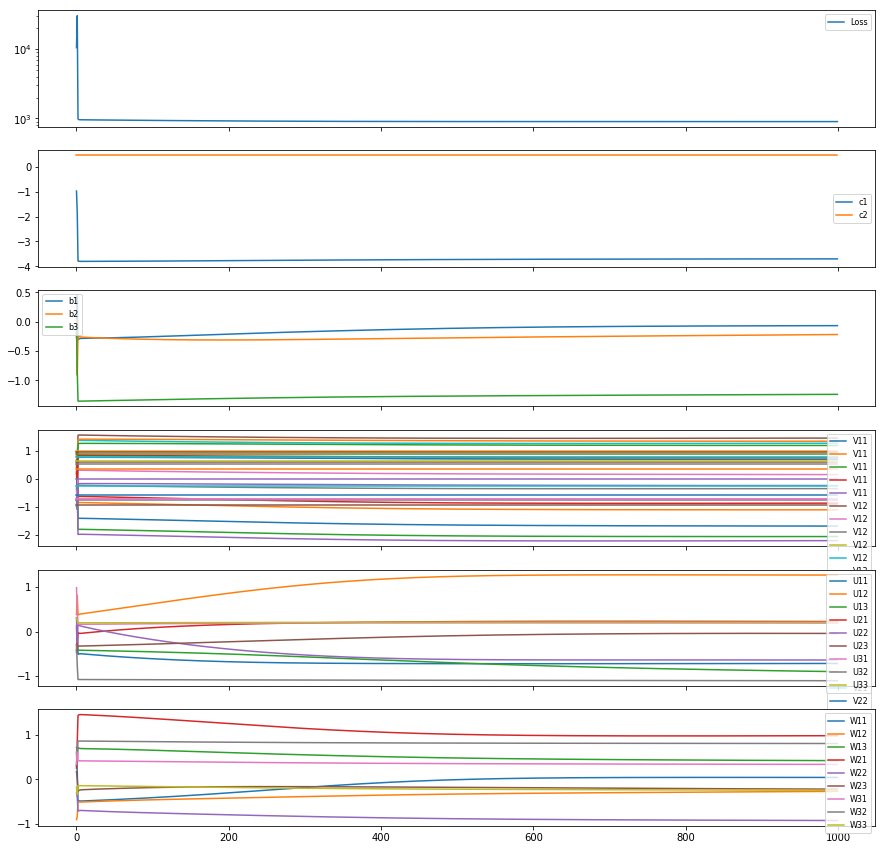

In [93]:
plot_model_evolution(Loss,b,c,U,V,W)

In [94]:
_,_,pred = prediction(b[-1],c[-1],U[-1],V[-1],W[-1],x)

C:\Users\sebi\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


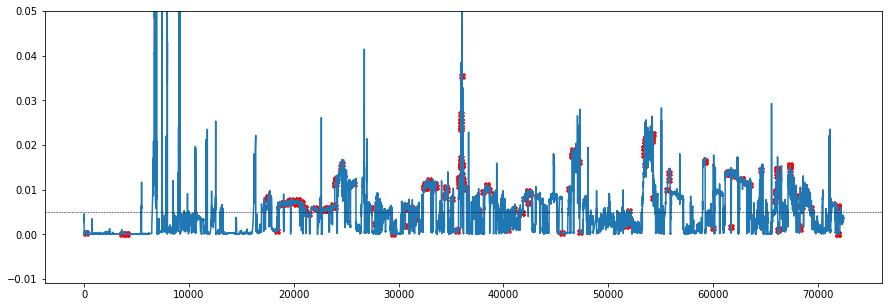

True Positives:   302
False Positives:  30427
False Negatives:  55
True Negatives:   41689


In [110]:
q = 0.005

plt.figure(figsize=(15,5))
plt.plot(pred[:,0])
for i in range(N):
    if y[i,0]==1.:
        plt.scatter(i,pred[i,0],c='r',marker='X')
plt.axhline(q,lw=0.5,ls='dashed',c='k')
#plt.yscale('log')
plt.ylim(top=0.05)
plt.savefig('RNN_Vexp_Loss900')
plt.show()

C = Confusionmatrix(y,pred,q)

In [100]:
savemodel('Loss_900.5',b[-1],c[-1],U[-1],V[-1],W[-1])

In [104]:
b,c,U,V,W = loadmodel('Loss_900.5',5)

In [101]:
np.shape(V)

(1000, 2, 3, 5)

In [99]:
def savemodel(savename,b,c,U,V,W):
    specification = 'RNN_Models/RNN_Vexp_'+savename+'_'
    np.savetxt(specification+'b',b)
    np.savetxt(specification+'c',c)
    np.savetxt(specification+'U',U)
    np.savetxt(specification+'W',W)
    for i in range(np.shape(V)[2]):
        np.savetxt(specification+'V'+str(i),V[:,:,i])

In [102]:
def loadmodel(savename,Vpast):
    specification = 'RNN_Models/RNN_Vexp_'+savename+'_'
    b = np.loadtxt(specification+'b')
    c = np.loadtxt(specification+'c')
    U = np.loadtxt(specification+'U')
    W = np.loadtxt(specification+'W')
    V = np.zeros((2,3,Vpast))
    for i in range(Vpast):
        V[:,:,i] = np.loadtxt(specification+'V'+str(i))
    return b,c,U,V,W